In [123]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.stats import skewnorm, rankdata

In [124]:
class createSet(object): # Make this subclass pd dataframe? #https://stackoverflow.com/questions/22155951/how-to-subclass-pandas-dataframe
    '''This creates pandas dataframe of a specified size with generated features of
    various distributions and a dependent variable of a specified skewness. 
    
    This class also has a few methods for creating additional, completely random features with 
    a function call. These can be of specified distribution but are truly random and are likely
    to have correlations close to zero with the target variable.
    
    The outlier method removes rows at random and replaces them with outliers: use "all" to get
    extreme values in every column, or specify 'columns=[]' to get outliers in only some features.
    '''
    
    def __init__(self,size=10000, targetskew=0, addCorrFeats=True):
        self.size = size
        #these two are counters that help create unique column names for generatable features later
        self.cons = 1
        self.cats = 1
        
        #create the target variable with the specified skewneww
        targetMean = 6000
        targetStd = 2000
        self.hoursSpent = skewnorm.rvs(a=targetskew,loc=targetMean,scale=targetStd, size=self.size)
        df = pd.DataFrame(self.hoursSpent, columns=['hoursSpent'])
        
        #Some of the features will be calculated using the target variable to artificially create some
        # correlation. However, I don't want them to automatically inherit the skewness of the target
        # variable, so instead of basing the independing variables directly on the target, I will 
        # create a normal distribution on the same scale that is sorted to match the order of the 
        # target variable. That enables creating correlated features without inheriting skew.
        sortedNormal = np.sort(skewnorm.rvs(a=0, loc=targetMean,scale=targetStd, size=self.size))
        self.normWithTargetSorting = [sortedNormal[i-1] for i in rankdata(self.hoursSpent, method='ordinal')]
        
        
        if addCorrFeats == True:
            #This adds a normally distributed feature that's typically around .65 correlation
            #df['screenActions'] = [int(x+np.random.randint(low=(targetMean - targetStd*2),
            #                        high=(targetMean + targetStd*2))) for x in self.normWithTargetSorting]
            df['screenActions'] = [int(x+np.random.normal(loc=0,scale=targetStd*1.5))
                                   for x in self.normWithTargetSorting]
            
            #This adds a uniformly distributed feature that's typically around .13 correlation
            def unif(self, p):
                return np.random.choice(a=[np.random.uniform(high=150),np.random.uniform(low=150.1,high=300)], p=p)
            df ['picsPerMonth'] = [unif(self,[.4,.6]) if x > targetMean else 
                                   unif(self,[.6,.4]) for x in self.normWithTargetSorting]
            
            #This adds a poisson distribution that's typically around .17 correlation
            df['timesDropped'] = [np.random.poisson(lam=1.5) if x > targetMean else 
                                  np.random.poisson(lam=1.0) for x in self.normWithTargetSorting]
            
            #This adds a dual-peak gamma distribution for owner age, typically around -.12 correlation
            def gam(self, p):
                return np.random.choice(a=[np.random.gamma(shape=25.0,scale=1),
                              np.random.gamma(shape=25.0,scale=1.8)], p=p)
            df['ownerAge'] = [gam(self,[.6,.4]) if x >targetMean else 
                              gam(self,[.4,.6]) for x in self.normWithTargetSorting]
            
            #This adds a bernoulli distribution for whether the phone is rooted, typically around .06 correlation
            df['rooted'] = [np.random.binomial(1, .05) if x > targetMean*1.5 else
                            np.random.binomial(1, .005) for x in self.normWithTargetSorting]
            
            #This adds a categorical variable that slightly corresponds to the target
            def osChoice(self, p):
                return np.random.choice(a=['iOS', 'Android', 'other'], p=p)
            df ['os'] = [osChoice(self,[.415,.575,.01]) if x > targetMean else 
                                   osChoice(self,[.335,.635,.03]) for x in self.normWithTargetSorting]
               
        self.df = df
        
    def addContFeatures(self, feats={'normal':1}):
        for shape, cnt in feats.items():
            if shape == 'normal':
                for j in range(cnt):
                    Y = np.random.normal(loc=targetMean,scale=targetStd, size=self.size)
                    self.df['normalFeat_'+str(self.cons)] = Y
                    self.cons=self.cons+1
            elif shape == 'uniform':
                for j in range(cnt):
                    Y = np.random.uniform(size=self.size)*(targetMean*2)
                    self.df['uniformFeat_'+str(self.cons)] = Y
                    self.cons=self.cons+1
            elif shape == 'poisson':
                for j in range(cnt):
                    Y = np.random.poisson(lam=1.0,size=self.size)
                    self.df['poissonFeat_'+str(self.cons)] = Y
                    self.cons=self.cons+1
            elif shape == 'gamma':
                for j in range(cnt):
                    Y = np.random.gamma(shape=2.0,scale=2,size=self.size)
                    self.df['gammaFeat_'+str(self.cons)] = Y
                    self.cons=self.cons+1
                    
                
            else:
                print('NOTE: received invalid distribution type. Try \"normal\", \"uniform\", or ')
    
    def addCatFeatures(self, feats={'sex':['male', 'female']}):
        for name, values in feats.items():
            odds = np.random.randint(low=0, high=len(values),size=self.size)
            self.df[name] = [values[x] for x in odds]
            del odds
            
    def addOutliers(self, cnt=5):
        #code this
        self.df = df
        
        
        
            
        

In [125]:
#this cell doesn't need to run; It checks 100 iterations of the class createSet() to see how the features
# tend to correlate with the target variable (given that they are generated dynamically)
#It's only useful when I update how a feature is calculated

import time
start = time.time()
screencorrs = []
picscorrs = []
dropscorrs = []
agecorrs = []
rootcorrs = []
for i in range(100):
    u = createSet(size=1000)
    cor = u.df.corr()
    screencorrs.append(cor.loc['hoursSpent','screenActions'])
    picscorrs.append(cor.loc['hoursSpent','picsPerMonth'])
    dropscorrs.append(cor.loc['hoursSpent','timesDropped'])
    agecorrs.append(cor.loc['hoursSpent','ownerAge'])
    rootcorrs.append(cor.loc['hoursSpent','rooted'])
print('Correlations: \n')
print('screenActions\n',np.mean(screencorrs),'\n', np.std(screencorrs), '\n')
print('picsPerMonth\n',np.mean(picscorrs),'\n', np.std(picscorrs), '\n')
print('timesDropped\n',np.mean(dropscorrs),'\n', np.std(dropscorrs), '\n')
print('ownerAge\n',np.mean(agecorrs),'\n', np.std(agecorrs), '\n')
print('rooted\n',np.mean(rootcorrs),'\n', np.std(rootcorrs), '\n')
print('done in ', time.time() - start, 'seconds')


Correlations: 

screenActions
 0.5528787803542022 
 0.021439672221102008 

picsPerMonth
 0.14352990385781214 
 0.02847210207540257 

timesDropped
 0.1755492267162595 
 0.030559484465821646 

ownerAge
 -0.13137172637752104 
 0.036485018967421456 

rooted
 0.06972118222461582 
 0.040340512416632154 

done in  12.584137678146362 seconds


---------------------------------------------------------------------------

---------------------------------------------------------------------------

---------------------------------------------------------------------------

---------------------------------------------------------------------------

_________________

In [126]:
#Let's create one for vizualization

viz = createSet(targetskew=0)
print(viz.df.shape)
display(viz.df.head())
viz.df.corr()

(10000, 7)


,hoursSpent,screenActions,picsPerMonth,timesDropped,ownerAge,rooted,os
0,4495.144031,1156,66.412752,1,48.204948,0,iOS
1,11004.923150,16552,58.245638,1,49.459189,0,Android
2,5652.279842,2196,264.427373,1,43.557445,0,Android
3,6343.819579,10338,41.841611,1,50.796696,0,Android
4,7619.963018,10534,243.282762,1,16.456551,0,iOS


,hoursSpent,screenActions,picsPerMonth,timesDropped,ownerAge,rooted
hoursSpent,1.000000,0.563929,0.148896,0.180408,-0.129043,0.079475
screenActions,0.563929,1.000000,0.090231,0.109128,-0.065220,0.054989
picsPerMonth,0.148896,0.090231,1.000000,0.057654,-0.031697,0.009514
timesDropped,0.180408,0.109128,0.057654,1.000000,-0.037155,0.029013
ownerAge,-0.129043,-0.065220,-0.031697,-0.037155,1.000000,-0.003032
rooted,0.079475,0.054989,0.009514,0.029013,-0.003032,1.000000


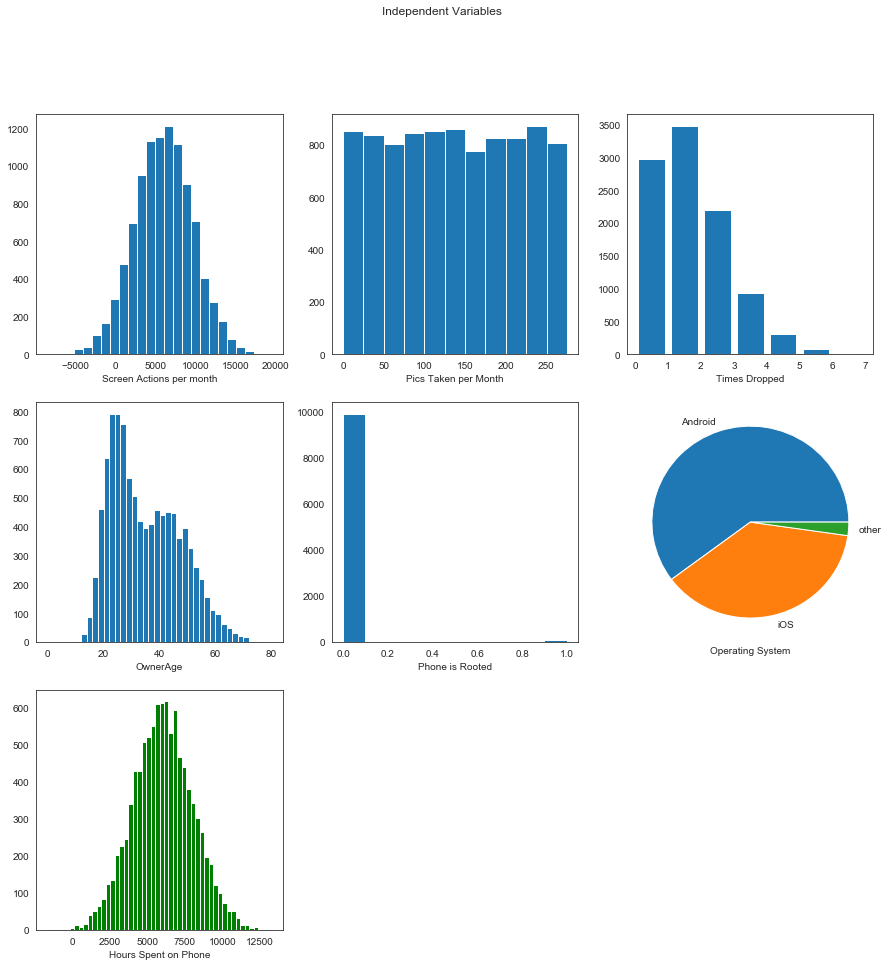

In [127]:
#Core feature Histograms

plt.figure(figsize=(15,15))
plt.suptitle('Independent Variables')
plt.subplot(331)
plt.hist(viz.df.screenActions, bins=25)
plt.xlabel('Screen Actions per month')
plt.subplot(332)
plt.hist(viz.df.picsPerMonth, bins=np.arange(0,max(viz.df.picsPerMonth),25))
plt.xlabel('Pics Taken per Month')
plt.subplot(333)
plt.hist(viz.df.timesDropped, bins=np.arange(0,max(viz.df.timesDropped),1), rwidth = .8)
plt.xlabel('Times Dropped')
plt.subplot(334)
plt.hist(viz.df.ownerAge, bins=np.arange(0,max(viz.df.ownerAge),2))
plt.xlabel('OwnerAge')
plt.subplot(335)
plt.hist(viz.df.rooted)#, bins=np.arange(0,40,3))
plt.xlabel('Phone is Rooted')
plt.subplot(336)
take.df['os'].value_counts().plot(kind='pie')
plt.xlabel('Operating System')
plt.ylabel('')
plt.subplot(337)
plt.hist(viz.df.hoursSpent, color='g', bins=50)#, bins=np.arange(0,40,3))
plt.xlabel('Hours Spent on Phone')

plt.show()







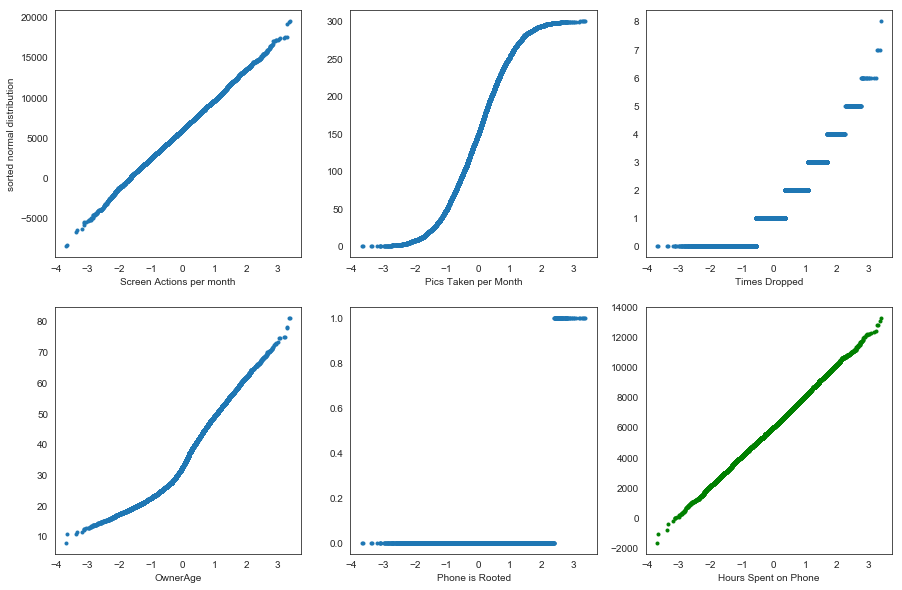

In [128]:
#Quartile Plot compared to random normal

norm = np.random.normal(0, 1, viz.size)
norm.sort()
norm1 = viz.df['screenActions'].sort_values()
uni2 =  viz.df['picsPerMonth'].sort_values()
pois3 =  viz.df['timesDropped'].sort_values()
gamma4 = viz.df['ownerAge'].sort_values()
bern = viz.df['rooted'].sort_values()
target = viz.df['hoursSpent'].sort_values()

plt.figure(figsize=(15,10))
plt.subplot(231)
plt.plot(norm, norm1, ".")
plt.ylabel('sorted normal distribution')
plt.xlabel('Screen Actions per month')
plt.subplot(232)
plt.plot(norm, uni2, ".")
plt.xlabel('Pics Taken per Month')
plt.subplot(233)
plt.plot(norm, pois3, ".")
plt.xlabel('Times Dropped')
plt.subplot(234)
plt.plot(norm, gamma4, ".")
plt.xlabel('OwnerAge')
plt.subplot(235)
plt.plot(norm, bern, ".")
plt.xlabel('Phone is Rooted')
plt.subplot(236)
plt.plot(norm, target, "g.")
plt.xlabel('Hours Spent on Phone')
plt.show()

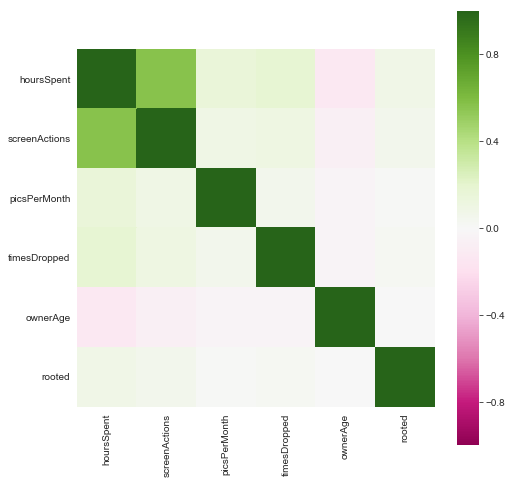

In [129]:
plt.figure(figsize=[8,8])
sns.heatmap(viz.df.corr(), vmin = -1,square=True, cmap="PiYG")
plt.show()

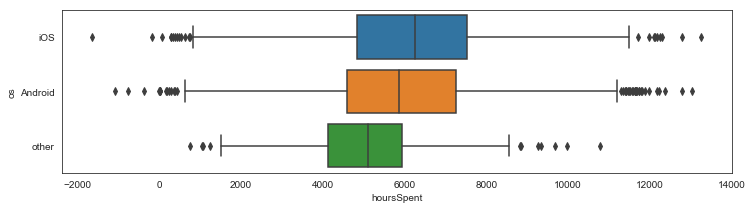

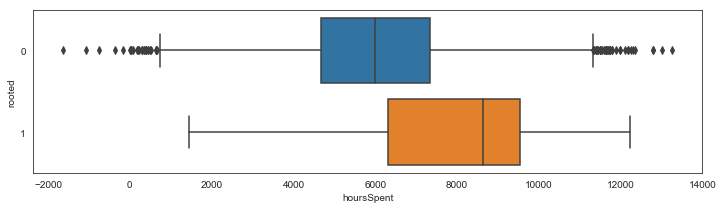

In [130]:
plt.figure(figsize=[12,3])
sns.boxplot(x='hoursSpent', y='os', data=viz.df, orient='h')
plt.show()
plt.figure(figsize=[12,3])
sns.boxplot(x='hoursSpent', y='rooted', data=viz.df, orient='h')
plt.show()

# Baseline: Linear Regression of a normally distributed dependent variable using 1 normally distributed feature

In [131]:
from sklearn import linear_model
from sklearn.model_selection import cross_val_score, cross_val_predict
import statsmodels.formula.api as smf
from statsmodels.sandbox.regression.predstd import wls_prediction_std


In [132]:
normal = createSet(targetskew=0, size=10000)
regr = linear_model.LinearRegression()

In [133]:
#sklearn
x = normal.df['screenActions']
y = normal.df['hoursSpent']
regr.fit(pd.DataFrame(x),y)
scores = cross_val_score(regr,pd.DataFrame(x),y,cv=10)
print("Fold Scores: ",scores)
print('Coefficients: \n', regr.coef_)
print('Intercept: \n', regr.intercept_)
print('-'*40)

#statsmodels

linear_formula = 'hoursSpent ~ screenActions'

# Fit the model to our data using the formula.
lm = smf.ols(formula=linear_formula, data=normal.df).fit()
lm.summary()

Fold Scores:  [0.26905893 0.32364457 0.32311237 0.31529394 0.24606248 0.30749186
 0.33753429 0.31278751 0.3161952  0.30417247]
Coefficients: 
 [0.30524359]
Intercept: 
 4118.724951748938
----------------------------------------


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             hoursSpent   R-squared:                       0.307
Model:                            OLS   Adj. R-squared:                  0.307
Method:                 Least Squares   F-statistic:                     4426.
Date:                Wed, 26 Dec 2018   Prob (F-statistic):               0.00
Time:                        13:35:48   Log-Likelihood:                -88363.
No. Observations:               10000   AIC:                         1.767e+05
Df Residuals:                    9998   BIC:                         1.767e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      4118.7250     32.308    127.482      0.000    4055.394    4182.056
screenActions     0.3052      0.005     66.527      0.000       0.296       0.314
==============================================================================
Omnibus:                        2.820   Durbin-Watson:                   2.038
Prob(Omnibus):                  0.244   Jarque-Bera (JB):                2.796
Skew:                          -0.031   Prob(JB):                        0.247
Kurtosis:                       3.053   Cond. No.                     1.37e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.37e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

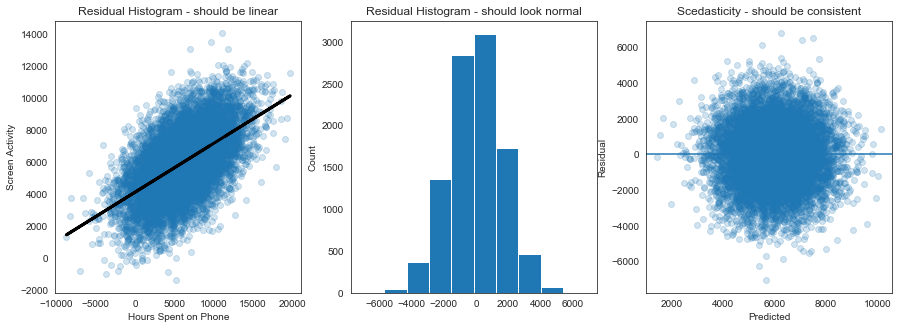

In [134]:
#Let's check how our output looks:
pred = cross_val_predict(regr,pd.DataFrame(x),y,cv=10)
residual = y - pred

plt.figure(figsize=[15,5])
plt.subplot(131)
plt.scatter(x,y, alpha=.2)
plt.plot(x, regr.predict(pd.DataFrame(x)), color='black', linewidth=3)
plt.title('Residual Histogram - should be linear')
plt.xlabel('Hours Spent on Phone')
plt.ylabel('Screen Activity')
plt.subplot(132)
plt.hist(residual)
plt.title('Residual Histogram - should look normal')
plt.ylabel('Count')
plt.subplot(133)
plt.scatter(pred, residual, alpha=.2)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Scedasticity - should be consistent')
plt.show()

# What if the target variable had a right skew instead of being normally distributed?

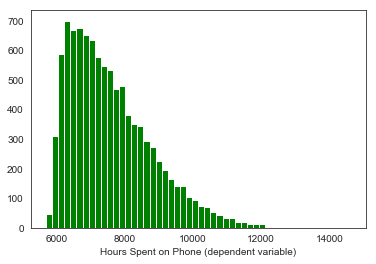

In [138]:
rightskew = createSet(targetskew=15, size=10000)
plt.hist(rightskew.df.hoursSpent, color='g', bins=50)
plt.xlabel('Hours Spent on Phone (dependent variable)')
plt.show()

regr = linear_model.LinearRegression()

In [139]:
#sklearn
x = rightskew.df['screenActions']
y = rightskew.df['hoursSpent']
regr.fit(pd.DataFrame(x),y)
scores = cross_val_score(regr,pd.DataFrame(x),y,cv=10)
print("Fold Scores: ",scores)
print('Coefficients: \n', regr.coef_)
print('Intercept: \n', regr.intercept_)
print('-'*40)

#statsmodels

linear_formula = 'hoursSpent ~ screenActions'

# Fit the model to our data using the formula.
lm = smf.ols(formula=linear_formula, data=rightskew.df).fit()
lm.summary()

Fold Scores:  [0.27688349 0.26518064 0.27172204 0.30103819 0.29254646 0.28554334
 0.28332697 0.27325692 0.2837416  0.25907205]
Coefficients: 
 [0.1780877]
Intercept: 
 6521.4461253139225
----------------------------------------


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             hoursSpent   R-squared:                       0.281
Model:                            OLS   Adj. R-squared:                  0.280
Method:                 Least Squares   F-statistic:                     3898.
Date:                Wed, 26 Dec 2018   Prob (F-statistic):               0.00
Time:                        13:36:57   Log-Likelihood:                -83572.
No. Observations:               10000   AIC:                         1.671e+05
Df Residuals:                    9998   BIC:                         1.672e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      6521.4461     20.008    325.935      0.000    6482.226    6560.667
screenActions     0.1781      0.003     62.436      0.000       0.172       0.184
==============================================================================
Omnibus:                      973.115   Durbin-Watson:                   2.006
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1322.481
Skew:                           0.798   Prob(JB):                    6.71e-288
Kurtosis:                       3.790   Cond. No.                     1.36e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.36e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

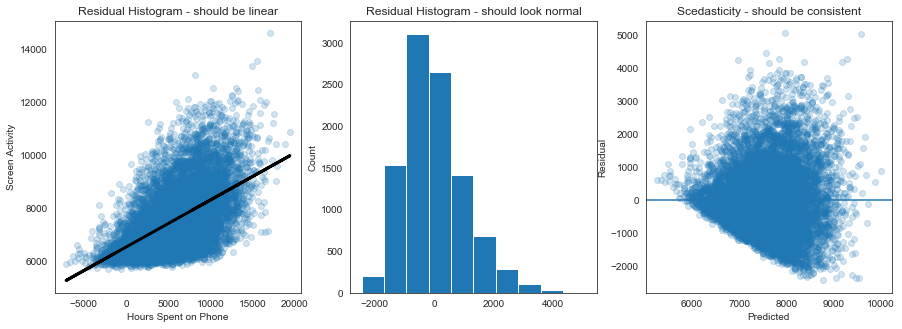

In [140]:
#Let's check how our output looks:
pred = cross_val_predict(regr,pd.DataFrame(x),y,cv=10)
residual = y - pred

plt.figure(figsize=[15,5])
plt.subplot(131)
plt.scatter(x,y, alpha=.2)
plt.plot(x, regr.predict(pd.DataFrame(x)), color='black', linewidth=3)
plt.title('Residual Histogram - should be linear')
plt.xlabel('Hours Spent on Phone')
plt.ylabel('Screen Activity')
plt.subplot(132)
plt.hist(residual)
plt.title('Residual Histogram - should look normal')
plt.ylabel('Count')
plt.subplot(133)
plt.scatter(pred, residual, alpha=.2)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Scedasticity - should be consistent')
plt.show()

work  in bayesian vs frequentist thinking
p values, priors etc.

logistic regression (over/under x hours?) to discuss ROC